# Packages

In [43]:
import os
import numpy as np
import pandas as pd
import pickle
import helper as hp

In [44]:
# Select state and upgrade id (0-10)
state = 'ny'
# state = 'ca'

upgrade_id = 10

data_dir = f'../Data_{state}/'
results_dir = f'../Results_{state}/'
fig_dir = f'../Figures_{state}/'

# Read metadata

In [45]:
# Set directories for EULP data
eulp_dir = '/mnt/data1/EULP/2022/'
resstock_amy2018_dir = os.path.join(eulp_dir, 'resstock_amy2018_release_1')

# List of upgrades
upgrade_list = ['upgrade%02d' %x for x in range(1, 11)]
upgrade_list.insert(0, 'baseline')
print(upgrade_list)

upgrade_list_num = ['upgrade=%d' %x for x in range(0, 11)]

['baseline', 'upgrade01', 'upgrade02', 'upgrade03', 'upgrade04', 'upgrade05', 'upgrade06', 'upgrade07', 'upgrade08', 'upgrade09', 'upgrade10']


In [46]:
# Read metadata
local_dir = os.path.join(resstock_amy2018_dir, 'metadata')

# Upgrade-specific metadata
upgrade = upgrade_list[upgrade_id]
filename = upgrade + '.parquet'
local_filename = os.path.join(local_dir, filename)
metadata_df = pd.read_parquet(local_filename, engine='pyarrow')

# Subset to state
metadata_state = metadata_df.loc[metadata_df['in.state'] == state.upper()]
metadata_state = metadata_state.reset_index()

# Save metadata to csv
resstock_amy2018_state_dir = os.path.join(data_dir, 'resstock_amy2018', f'{state}')
metadata_dir = os.path.join(data_dir, 'resstock_amy2018', 'metadata')
if not os.path.isdir(metadata_dir):
    os.makedirs(metadata_dir)
metadata_state.to_csv(os.path.join(metadata_dir,
                        f'resstock_metadata_{state}_{upgrade_id}.csv'))

metadata_state

,bldg_id,applicability,in.sqft,weight,in.ahs_region,in.ashrae_iecc_climate_zone_2004,in.ashrae_iecc_climate_zone_2004_2_a_split,in.bathroom_spot_vent_hour,in.bedrooms,in.building_america_climate_zone,...,out.electricity.total.energy_consumption,out.electricity.total.energy_consumption_intensity,out.fuel_oil.total.energy_consumption,out.fuel_oil.total.energy_consumption_intensity,out.natural_gas.total.energy_consumption,out.natural_gas.total.energy_consumption_intensity,out.propane.total.energy_consumption,out.propane.total.energy_consumption_intensity,upgrade,metadata_index
0,10,True,885.0,242.131013,Non-CBSA Middle Atlantic,5A,5A,Hour22,1,Cold,...,11254.222159,12.716635,0.0,0.0,0.0,0.0,0.0,0.0,10,5489168
1,11,True,1138.0,242.131013,"CBSA New York-Newark-Jersey City, NY-NJ-PA",4A,4A,Hour0,2,Mixed-Humid,...,5762.363378,5.063588,0.0,0.0,0.0,0.0,0.0,0.0,10,5489169
2,27,True,1623.0,242.131013,"CBSA New York-Newark-Jersey City, NY-NJ-PA",4A,4A,Hour15,2,Mixed-Humid,...,7505.843174,4.624672,0.0,0.0,0.0,0.0,0.0,0.0,10,5489185
3,64,True,853.0,242.131013,"CBSA New York-Newark-Jersey City, NY-NJ-PA",4A,4A,Hour22,2,Mixed-Humid,...,6681.434254,7.832865,0.0,0.0,0.0,0.0,0.0,0.0,10,5489222
4,67,True,2663.0,242.131013,Non-CBSA Middle Atlantic,5A,5A,Hour8,5,Cold,...,17590.711764,6.605600,0.0,0.0,0.0,0.0,0.0,0.0,10,5489225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33671,549854,True,853.0,242.131013,"CBSA New York-Newark-Jersey City, NY-NJ-PA",4A,4A,Hour4,1,Mixed-Humid,...,2030.103302,2.379957,0.0,0.0,0.0,0.0,0.0,0.0,10,6037930
33672,549873,True,853.0,242.131013,"CBSA New York-Newark-Jersey City, NY-NJ-PA",4A,4A,Hour6,2,Mixed-Humid,...,4860.876767,5.698566,0.0,0.0,0.0,0.0,0.0,0.0,10,6037949
33673,549906,True,2663.0,242.131013,Non-CBSA Middle Atlantic,5A,5A,Hour3,4,Cold,...,5581.538528,2.095959,0.0,0.0,0.0,0.0,0.0,0.0,10,6037981
33674,549920,True,1138.0,242.131013,"CBSA New York-Newark-Jersey City, NY-NJ-PA",5A,5A,Hour8,1,Cold,...,6969.816187,6.124619,0.0,0.0,0.0,0.0,0.0,0.0,10,6037995


In [47]:
# Create a list of county IDs
county_id_list = metadata_state['in.county'].drop_duplicates().to_list()
county_id_list.sort()

# Get lists of unique hvac types
res_heating_type_list = list(pd.unique(metadata_state['in.hvac_heating_type']))
print('Heating technologies:', res_heating_type_list)
res_cooling_type_list = list(pd.unique(metadata_state['in.hvac_cooling_type']))
print('Cooling technologies:', res_cooling_type_list)

Heating technologies: ['Ducted Heating', 'Non-Ducted Heating', 'None', 'Ducted Heat Pump']
Cooling technologies: ['Room AC', 'Central AC', 'None', 'Heat Pump']


In [48]:
# Read correction factors for resstock in state
res_corr =  pd.read_csv(os.path.join(resstock_amy2018_state_dir, f'correction_factors_{state}_2018.csv'))
res_corr = pd.concat([res_corr, res_corr.tail(1)], axis=0)
date_list = pd.date_range('2018-01-01', '2019-01-01', freq='1D')
res_corr = res_corr.set_index(date_list)
res_corr = res_corr.drop(columns=['Month', 'day_of_month', 'build_existing_model.state'])
res_corr = res_corr.resample('1H').ffill()
res_corr = res_corr.drop(res_corr.tail(1).index)

In [49]:
# Directory for downloaded individual building timeseries data
eulp_ts_dir = os.path.join(resstock_amy2018_dir, 'timeseries_individual_buildings', 'by_state')
upgrade_state_dir = os.path.join(eulp_ts_dir,
                                f'upgrade={upgrade_id}',
                                f'state={state.upper()}')

assert os.path.isdir(upgrade_state_dir)

# Directory for processed data output
resstock_amy2018_bldg_dir = f'../Data_{state}/resstock_amy2018/building/'
resstock_amy2018_bldg_processed_dir = os.path.join(resstock_amy2018_bldg_dir, 'euss_processed', f'upgrade={upgrade_id}')

if not os.path.isdir(resstock_amy2018_bldg_processed_dir):
    os.makedirs(resstock_amy2018_bldg_processed_dir)

overwrite = False


# Process building energy timeseries data

In [50]:
for county_id in county_id_list:
    print('County ID:', county_id)

    # If processed pickle file doesn't already exist, process the data
    out_filename = os.path.join(resstock_amy2018_bldg_processed_dir, f'{county_id}_elec_total.pkl')
    
    if not os.path.isfile(out_filename) or overwrite:
        # Create a subset of buildings in the county
        cond = (metadata_state['in.county']==county_id)
        res_bldg_id_sublist = list(metadata_state[cond]['bldg_id'])
        res_bldg_wt_sublist = list(metadata_state[cond]['weight'])

        print('Number of buildings: ', len(res_bldg_id_sublist))

        # Loop through individual buildings
        for bldg_id, bldg_wt in zip(res_bldg_id_sublist, res_bldg_wt_sublist):
            filename = f'{bldg_id}-{upgrade_id}.parquet'
            local_filename = os.path.join(upgrade_state_dir, filename)

            # Read the parquet file if exists
            if os.path.isfile(local_filename):
                try:
                    df = pd.read_parquet(local_filename, engine='pyarrow')
                    df = df.reset_index()
                    # Get hourly net electricity consumption raw data
                    elec_total = hp.process_hourly(df, col_name=['out.electricity.total.energy_consumption'])
                    # Get hourly weighted hourly consumption
                    elec_total = elec_total*bldg_wt

                    if bldg_id == res_bldg_id_sublist[0]:
                        # Read in the first dataframe
                        elec_total_county = elec_total
                    else:
                        # Add to county level data
                        elec_total_county = elec_total_county + elec_total

                except:
                    print(f"Error with file {local_filename}")
                    raise

        # Write to pickle
        pickle.dump(elec_total_county, open(out_filename, 'wb') ) 
        print('Finished processing data and saved in:', out_filename)
    else:
        # print('Processed file already exists:', out_filename)
        pass

County ID: G3600010
County ID: G3600030
County ID: G3600050
County ID: G3600070
County ID: G3600090
County ID: G3600110
County ID: G3600130
County ID: G3600150
County ID: G3600170
County ID: G3600190
County ID: G3600210
County ID: G3600230
County ID: G3600250
County ID: G3600270
County ID: G3600290
County ID: G3600310
County ID: G3600330
County ID: G3600350
County ID: G3600370
County ID: G3600390
County ID: G3600410
County ID: G3600430
County ID: G3600450
County ID: G3600470
County ID: G3600490
County ID: G3600510
County ID: G3600530
County ID: G3600550
County ID: G3600570
County ID: G3600590
County ID: G3600610
County ID: G3600630
County ID: G3600650
County ID: G3600670
County ID: G3600690
County ID: G3600710
County ID: G3600730
County ID: G3600750
County ID: G3600770
County ID: G3600790
County ID: G3600810
County ID: G3600830
County ID: G3600850
County ID: G3600870
County ID: G3600890
County ID: G3600910
County ID: G3600930
County ID: G3600950
County ID: G3600970
County ID: G3600990


# Calculate electricity demand in NYC

In [51]:
# NYC county list
nyc_county_id_list = [
    'G3600050', # Bronx County
    'G3600470', # Kings County
    'G3600610', # New York County
    'G3600810', # Queens County
    'G3600850' # Richmond County
]

In [52]:
nyc_elec_total_list = list()

# Read data for each county in NYC
for county_id in nyc_county_id_list:
    
    # Set up filename
    out_filename = os.path.join(resstock_amy2018_bldg_processed_dir, f'{county_id}_elec_total.pkl')

    # Read pickled data
    elec_total_county = pickle.load(open(out_filename, 'rb'))

    nyc_elec_total_list.append(elec_total_county)

# Combine the data
nyc_elec_total = pd.concat(nyc_elec_total_list, axis=1)
nyc_elec_total.columns = nyc_county_id_list
nyc_elec_total

,G3600050,G3600470,G3600610,G3600810,G3600850
timestamp,,,,,
2018-01-01 00:00:00,8.624574e+05,1.862654e+06,1.113627e+06,2.129127e+06,482758.391866
2018-01-01 01:00:00,9.489824e+05,2.066451e+06,1.241472e+06,2.376703e+06,533441.981843
2018-01-01 02:00:00,9.961926e+05,2.190445e+06,1.348308e+06,2.416884e+06,570721.925348
2018-01-01 03:00:00,1.049819e+06,2.315372e+06,1.368641e+06,2.415982e+06,618413.744532
2018-01-01 04:00:00,1.146736e+06,2.545837e+06,1.417554e+06,2.579252e+06,689596.388178
...,...,...,...,...,...
2018-12-31 19:00:00,5.529023e+05,1.135695e+06,7.811439e+05,1.112451e+06,270332.496042
2018-12-31 20:00:00,5.075315e+05,1.049926e+06,7.253727e+05,1.025720e+06,248813.344417
2018-12-31 21:00:00,4.557557e+05,9.456064e+05,6.529593e+05,9.158574e+05,224422.518980


<AxesSubplot:title={'center':'NYC residential electricity demand'}, xlabel='timestamp'>

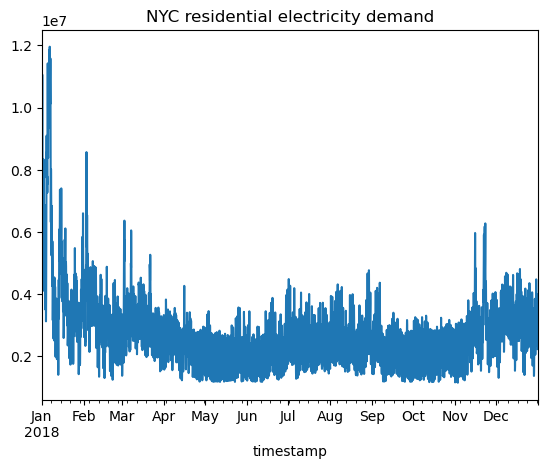

In [53]:
# NYC total demand
nyc_elec_total_sum = nyc_elec_total.sum(axis=1)
nyc_elec_total_sum.name = 'elec_total'

nyc_elec_total_sum.plot(title='NYC residential electricity demand')


In [54]:
# Save to csv
nyc_out_dir = os.path.join(results_dir, 'euss_nyc')
if not os.path.isdir(nyc_out_dir):
    os.makedirs(nyc_out_dir)
nyc_elec_total_sum.to_csv(os.path.join(nyc_out_dir,
                            f'nyc_elec_total_{upgrade_id}.csv'))

In [55]:
# for county_id in county_id_list:
#     print('County ID:', county_id)

#     # If processed pickle file doesn't already exist, process the data
#     filename = os.path.join(resstock_amy2018_bldg_processed_dir, f'{county_id}_heat.pkl')
#     if not os.path.isfile(filename) or overwrite:
        
#         # Loop through hvac heating types
#         res_bldg_heating_tot_dict = dict()
#         for heating_type in res_heating_type_list:
#             cond = (metadata_state['in.county']==county_id) & (metadata_state['in.hvac_heating_type']==heating_type)
#             res_bldg_id_sublist = list(metadata_state[cond]['bldg_id'])
#             res_bldg_wt_sublist = list(metadata_state[cond]['weight'])
#             print(heating_type, ':', len(res_bldg_id_sublist))
#             if len(res_bldg_id_sublist) > 0:
#                 res_bldg_heating_tot_dict[heating_type] = hp.calc_bldg_ts_tot(upgrade_id = upgrade_id,
#                                                                                 bldg_id_sublist = res_bldg_id_sublist, 
#                                                                                 bldg_wt_sublist = res_bldg_wt_sublist, 
#                                                                                 data_dir = upgrade_state_dir, 
#                                                                                 res_corr = res_corr)
#             else:
#                 res_bldg_heating_tot_dict[heating_type] = None
#         # Write to pickle
#         pickle.dump(res_bldg_heating_tot_dict, open(filename, 'wb') )
#         print('Finished processing data and saved in:', filename)
#     else:
#         print('Processed file already exists:', filename)

In [56]:
# Process data grouped by heating and cooling tech
# for county_id in county_id_list:
#     print('County ID', county_id)
#     # If county's directory exists
#     county_dir = os.path.join(resstock_amy2018_bldg_dir, county_id)
#     if os.path.isdir(county_dir):
        
#         # If processed pickle file doesn't already exist, process the data
#         filename = os.path.join(resstock_amy2018_bldg_processed_dir, f'{county_id}_heat.pkl')
#         if not os.path.isfile(filename) or overwrite:
#             # Loop through hvac heating types
#             res_bldg_heating_tot_dict = dict()
#             for heating_type in res_heating_type_list:
#                 cond = (res_building_state['in.county']==county_id) & (res_building_state['in.hvac_heating_type']==heating_type)
#                 res_bldg_id_sublist = list(res_building_state[cond]['bldg_id'])
#                 res_bldg_wt_sublist = list(res_building_state[cond]['weight'])
#                 print(heating_type, ':', len(res_bldg_id_sublist))
#                 if len(res_bldg_id_sublist) > 0:
#                     res_bldg_heating_tot_dict[heating_type] = hp.calc_bldg_ts_tot(res_bldg_id_sublist, res_bldg_wt_sublist, 
#                                                                                     county_dir, res_corr)
#                 else:
#                     res_bldg_heating_tot_dict[heating_type] = None
#             # Write to pickle
#             pickle.dump(res_bldg_heating_tot_dict, open(filename, 'wb') )
#             print('Finished processing data and saved in:', filename)
#         else:
#             print('Processed file already exists:', filename)

#         # If processed pickle file doesn't already exist, process the data
#         filename = os.path.join(resstock_amy2018_bldg_processed_dir, f'{county_id}_cool.pkl')
#         if not os.path.isfile(filename) or overwrite:
#             # Loop through hvac cooling types
#             res_bldg_cooling_tot_dict = dict()
#             for cooling_type in res_cooling_type_list:
#                 cond = (res_building_state['in.county']==county_id) & (res_building_state['in.hvac_cooling_type']==cooling_type)
#                 res_bldg_id_sublist = list(res_building_state[cond]['bldg_id'])
#                 res_bldg_wt_sublist = list(res_building_state[cond]['weight'])
#                 print(cooling_type, ':', len(res_bldg_id_sublist))
#                 if len(res_bldg_id_sublist) > 0:
#                     res_bldg_cooling_tot_dict[cooling_type] = hp.calc_bldg_ts_tot(res_bldg_id_sublist, res_bldg_wt_sublist, 
#                                                                                     county_dir, res_corr)
#                 else:
#                     res_bldg_cooling_tot_dict[cooling_type] = None
#             # Write to pickle
#             pickle.dump(res_bldg_cooling_tot_dict, open(filename, 'wb'))
#             print('Finished processing data and saved in:', filename)
#         else:
#             print('Processed file already exists:', filename)